In [1]:
from dataclasses import dataclass
import math
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

import pickle
import os
import cv2 as cv
import kornia as KR
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse
from pipeline import Pipeline
from kornia_moons.feature import *
from config import CartesianConfig
from hard_net_descriptor import HardNetDescriptor
from utils import Timer
from rectification import get_rotation_matrix



bin angle: degrees: 35, distance: 0.6014115990085462
seed inter cluster angle: degrees: 35, distance: 1.3830261115645386
mean shift seed inter cluster angle: degrees: 35, distance: 1.147152872702092
Loading weights for net_encoder
Loading weights for net_decoder


In [6]:
def get_rotation_matrices(unit_rotation_vectors, thetas):

    # Rodrigues formula
    # R = I + sin(theta) . K + (1 - cos(theta)).K**2

    K = torch.zeros([*unit_rotation_vectors.shape[:2], *[3, 3]])

    # K[:, :, 0, 0] = 0.0
    K[:, :, 0, 1] = -unit_rotation_vectors[:, :, 2]
    K[:, :, 0, 2] = unit_rotation_vectors[:, :, 1]
    K[:, :, 1, 0] = unit_rotation_vectors[:, :, 2]
    # K[:, :, 1, 1] = 0.0
    K[:, :, 1, 2] = -unit_rotation_vectors[:, :, 0]

    K[:, :, 2, 0] = -unit_rotation_vectors[:, :, 1]
    K[:, :, 2, 1] = unit_rotation_vectors[:, :, 0]
    # K[:, :, 2, 2] = 0.0

    a = torch.eye(3)[None, None]

    b = torch.sin(thetas).unsqueeze(3) * K

    c = (1.0 - torch.cos(thetas)).unsqueeze(3) * K @ K

    R = a + b + c

    a0 = torch.eye(3)
    b0 = torch.sin(thetas[0, 0]) * K[0, 0]
    c0 = (1.0 - torch.cos(thetas[0, 0])) * K[0, 0] @ K[0, 0]
    R0 = a0 + b0 + c0

    R1 = get_rotation_matrix(unit_rotation_vectors[0, 0], thetas[0, 0])

    assert torch.all(R[0,0] == R0)
    assert torch.allclose(R[0,0], torch.from_numpy(R1).to(torch.float))

    return R


def get_lafs(file_path, descriptor, img_name):

    img = cv.cvtColor(cv.imread(file_path), cv.COLOR_BGR2RGB)
    plt.figure(figsize=(9, 9))
    plt.title(img_name)
    plt.imshow(img)
    plt.close()

    kps, descs, laffs = descriptor.detectAndCompute(img, give_laffs=True, filter=hard_net_filter)

    timg = KR.image_to_tensor(img, False).float() / 255.

    # Let's visualize some of the local features
    title = "{} - all unrectified affnet features".format(img_name)
    visualize_LAF_custom(timg, laffs, title=title, figsize=(8, 12))

    scale1 = KF.get_laf_scale(laffs)
    lafs_no_scale = KF.scale_laf(laffs, 1. / scale1)

    return kps, descs, lafs_no_scale


def prepare_pipeline():

    Timer.start_check_point("prepare_pipeline")

    pipeline, config_map = Pipeline.configure("config.txt", None)
    pipeline.output_dir = "affnet_demo"
    all_configs = CartesianConfig.get_configs(config_map)
    config, cache_map = all_configs[0]
    pipeline.config = config
    pipeline.cache_map = cache_map

    pipeline.start()
    Timer.end_check_point("prepare_pipeline")

    return pipeline


def get_kpts_components_indices(components_indices, valid_components_dict, laffs_no_scale):

    Timer.start_check_point("get_kpts_components_indices")

    coords = laffs_no_scale[0, :, :, 2]
    coords = torch.round(coords)
    torch.clamp(coords[:, 0], 0, components_indices.shape[1] - 1, out=coords[:, 0])
    torch.clamp(coords[:, 1], 0, components_indices.shape[0] - 1, out=coords[:, 1])
    coords = coords.to(torch.long)

    component_indices = components_indices[coords[:, 1], coords[:, 0]]
    normals_indices = torch.ones_like(coords[:, 0]) * -1
    for valid_component in valid_components_dict:
        normals_indices[component_indices == valid_component] = valid_component

    Timer.end_check_point("get_kpts_components_indices")

    return normals_indices[None]


def compose_lin_maps(ts, phis, lambdas=None, psis=None):

    if lambdas is None:
        lambdas = 1.0 / torch.sqrt(ts)
        lambdas = lambdas.repeat(1, 1, 1, 1)
    if psis is None:
        psis = torch.zeros_like(phis)

    def get_rotation_matrices(angles):
        R = torch.cos(angles)
        R = R.repeat(1, 1, 2, 2)
        R[:, :, 1, 0] = torch.sin(angles)
        R[:, :, 0, 1] = -R[:, :, 1, 0]
        return R

    R_psis = get_rotation_matrices(psis)
    R_phis = get_rotation_matrices(phis)

    T_ts = torch.zeros_like(ts)
    T_ts = T_ts.repeat(1, 1, 2, 2)
    T_ts[:, :, 0, 0] = ts
    T_ts[:, :, 1, 1] = 1

    lin_maps = lambdas * R_psis @ T_ts @ R_phis
    return lin_maps, lambdas, R_psis, T_ts, R_phis


def decompose_lin_maps(l_maps, asserts=True):

    assert len(l_maps.shape) == 4
    Timer.start_check_point("decompose_lin_maps")

    # NOTE for now just disallow CUDA
    assert l_maps.device == torch.device('cpu')

    U, s, V = torch.svd(l_maps)
    V = torch.transpose(V, dim0=2, dim1=3)

    lambdas = torch.ones(l_maps.shape[:2])

    def assert_decomposition():
        d = torch.diag_embed(s)
        product = lambdas.view(1, -1, 1, 1) * U @ d @ V
        close_cond = torch.allclose(product, l_maps, atol=1e-05)
        assert close_cond

    assert_decomposition()

    if asserts:
        assert torch.all(torch.sgn(s[:, :, 0]) == torch.sgn(s[:, :, 1]))
        assert torch.all(s[:, :, 0] != 0)

    # TODO this is probably useless as factor will be 1
    factor = torch.sgn(s[:, :, :1])
    U = factor[:, :, :, None] * U
    s = factor * s

    # lambda <- s[1]
    # s <- [[t, 0], [0, 1]], t >= 1
    lambdas = s[:, :, 1].clone()
    s = s / s[:, :, 1:]

    assert_decomposition()

    if asserts:
        assert torch.all(s[:, :, 0] >= 1)
        assert torch.all(s[:, :, 1] == 1)

    dets_u = torch.det(U)
    dets_v = torch.det(V)
    if asserts:
        assert torch.allclose(dets_v, dets_u, atol=1e-07)
        assert torch.allclose(torch.abs(dets_v), torch.tensor(1.0), atol=1e-07)

    # it could be that det U[:, :, i] == det V[:, :, i] == -1, therefore I need to negate row(U, 0) and column(V, 0) -> two reflections
    factor_rows_columns = torch.where(dets_v > 0.0, 1.0, -1.0).view(1, -1, 1)
    U[:, :, :, 0] = factor_rows_columns * U[:, :, :, 0]
    V[:, :, 0, :] = factor_rows_columns * V[:, :, 0, :]

    assert_decomposition()

    dets_u = torch.det(U)
    dets_v = torch.det(V)
    if asserts:
        assert torch.allclose(dets_v, dets_u, atol=1e-07)
        assert torch.allclose(dets_v, torch.tensor(1.0), atol=1e-07)

    # phi in (0, pi), if not, V <- -V and U <- -U
    phi_norm_factor = torch.where(V[:, :, :1, 1:] > 0, -1.0, 1.0)
    V = V * phi_norm_factor
    U = U * phi_norm_factor

    def assert_rotation(A, angle):
        sins_ang = torch.sin(angle)
        if asserts:
            assert torch.allclose(sins_ang, -A[:, :, 0, 1], atol=1e-03)
            assert torch.allclose(sins_ang, A[:, :, 1, 0], atol=1e-03)
            assert torch.allclose(A[:, :, 1, 1], A[:, :, 0, 0], atol=1e-05)

    phis = torch.arccos(torch.clamp(V[:, :, 0, 0], -1.0, 1.0))
    assert_rotation(V, phis)

    psis = torch.arcsin(-torch.clamp(U[:, :, 0, 1], -1.0, 1.0))
    assert_rotation(U, psis)

    ts = s[:, :, 0]

    assert_decomposition()
    Timer.end_check_point("decompose_lin_maps")

    return lambdas, psis, ts, phis


def draw(radius, ts, phis, color, size, ax):

    ts_logs = torch.log(ts)
    xs = torch.cos(phis) * ts_logs
    ys = torch.sin(phis) * ts_logs

    ax.plot(xs, ys, 'o', color=color, markersize=size)


def prepare_plot(radius: float, ax):

    log_radius = math.log(radius)

    ax.set_aspect(1.0)

    factor = 1.2
    ax.set_xlim((-factor*log_radius, factor*log_radius))
    ax.set_ylim((-factor*log_radius, factor*log_radius))

    circle = Circle((0, 0), log_radius, color='r', fill=False)
    ax.add_artist(circle)


def get_aff_map(img, t, phi, component_mask, invert_first):

    lin_map = compose_lin_maps(t, phi)[0]
    if not invert_first:
        lin_map = torch.inverse(lin_map)
    aff_map = torch.zeros((1, 2, 3))
    aff_map[:, :2, :2] = lin_map

    coords = torch.where(component_mask)
    min_x = coords[1].min()
    max_x = coords[1].max()
    min_y = coords[0].min()
    max_y = coords[0].max()

    corner_pts = torch.tensor([[min_x, min_y],
                               [min_x, max_y],
                               [max_x, max_y],
                               [max_x, min_y]], dtype=torch.float)[None]

    H = KR.geometry.convert_affinematrix_to_homography(aff_map)
    corner_pts_new = KR.geometry.transform_points(H, corner_pts)

    aff_map[:, :, 2] = -torch.tensor([corner_pts_new[0, :, 0].min(), corner_pts_new[0, :, 1].min()])

    new_w = int((corner_pts_new[0, :, 0].max() - corner_pts_new[0, :, 0].min()).item())
    new_h = int((corner_pts_new[0, :, 1].max() - corner_pts_new[0, :, 1].min()).item())
    t_img = KR.image_to_tensor(img, False).float() / 255.

    return aff_map, new_h, new_w, t_img


@dataclass
class PointsStyle:
    ts: torch.tensor
    phis: torch.tensor
    color: str
    size: float


def plot_space_of_tilts(label, img_name, valid_component, normal_index, exp_r, point_styles: list):

    fig, ax = plt.subplots()
    plt.title("{}: {} - component {} / normal {}".format(label, img_name, valid_component, normal_index))
    prepare_plot(exp_r, ax)
    for point_style in point_styles:
        draw(exp_r, point_style.ts, point_style.phis, point_style.color, point_style.size, ax)
    plt.show()


def visualize_LAF_custom(img, LAF, img_idx=0, color='r', title="", **kwargs):
    x, y = KR.feature.laf.get_laf_pts_to_draw(KR.feature.laf.scale_laf(LAF, 0.5), img_idx)
    plt.figure(**kwargs)
    plt.title(title)
    plt.imshow(KR.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, color)
    plt.show()
    return


def affnet_process(pipeline, img_name, hardnet, invert_first, img_data):

    img_file_path = pipeline.scene_info.get_img_file_path(img_name)

    img = cv.cvtColor(cv.imread(img_file_path), cv.COLOR_BGR2RGB)
    _, _, laffs_no_scale = get_lafs(img_file_path, hardnet, img_name)

    lin_map = laffs_no_scale[:, :, :, :2]

    if invert_first:
        lin_map = torch.inverse(lin_map)

    _, _, ts, phis = decompose_lin_maps(lin_map)

    kpts_component_indices = get_kpts_components_indices(img_data.components_indices, img_data.valid_components_dict, laffs_no_scale)

    label = "inverted all" if invert_first else "not inverted all"
    print("{}: count: {}".format(label, ts.shape))
    plot_space_of_tilts(label, img_name, 0, 0, tilt_r, [
        PointsStyle(ts=ts, phis=phis, color="b", size=0.5),
    ])

    all_kps = []
    all_desc = np.zeros((0, 128))
    all_laffs = torch.zeros(1, 0, 2, 3)

    for current_component in img_data.valid_components_dict:

        normal_index = img_data.valid_components_dict[current_component]

        print("processing component->normal: {} -> {}".format(current_component, normal_index))

        mask = kpts_component_indices == current_component
        ts_affnet, phis_affnet = ts[mask], phis[mask]
        t_mean_affnet = torch.mean(ts_affnet)
        phi_mean_affnet = torch.mean(phis_affnet)

        label = "inverted unrectified" if invert_first else "not inverted unrectified"
        print("{}: count: {}".format(label, ts_affnet.shape))
        plot_space_of_tilts(label, img_name, current_component, normal_index, tilt_r, [
            PointsStyle(ts=ts_affnet, phis=phis_affnet, color="b", size=0.5),
            PointsStyle(ts=t_mean_affnet, phis=phi_mean_affnet, color="r", size=3)
        ])

        mask_img_component = torch.from_numpy(img_data.components_indices == current_component)
        aff_maps, new_h, new_w, t_img = get_aff_map(img, t_mean_affnet, phi_mean_affnet, mask_img_component, invert_first)

        img_normal_component_title = "{} - warped component {}, normal {}".format(img_name, current_component, normal_index)
        img_warped_t = KR.geometry.warp_affine(t_img, aff_maps, dsize=(new_h, new_w))
        img_warped = KR.tensor_to_image(img_warped_t * 255.0).astype(dtype=np.uint8)
        plt.figure(figsize=(6, 8))
        plt.title(img_normal_component_title)
        plt.imshow(img_warped)
        plt.show()

        kps_warped, descs_warped, laffs_final = hardnet.detectAndCompute(img_warped, give_laffs=True, filter=hard_net_filter)

        aff_maps_inv = KR.geometry.transform.invert_affine_transform(aff_maps)

        kps_t = torch.tensor([kp.pt + (1,) for kp in kps_warped])
        kpt_s_back = aff_maps_inv.repeat(kps_t.shape[0], 1, 1) @ kps_t.unsqueeze(2)
        kpt_s_back = kpt_s_back.squeeze(2)

        laffs_final[0, :, :, 2] = kpt_s_back

        kpt_s_back_int = torch.round(kpt_s_back).to(torch.long)
        mask = (kpt_s_back_int[:, 1] < img.shape[0]) & (kpt_s_back_int[:, 1] >= 0) & (kpt_s_back_int[:, 0] < img.shape[1]) & (kpt_s_back_int[:, 0] >= 0)
        print("invalid back transformed pixels: {}/{}".format(mask.shape[0] - mask.sum(), mask.shape[0]))

        kpt_s_back_int[~mask, 0] = 0
        kpt_s_back_int[~mask, 1] = 0
        mask = (mask) & (img_data.components_indices[kpt_s_back_int[:, 1], kpt_s_back_int[:, 0]] == current_component)
        mask = mask.to(torch.bool)

        kps = []
        for i, kp in enumerate(kps_warped):
            if mask[i]:
                kp.pt = (kpt_s_back[i][0].item(), kpt_s_back[i][1].item())
                kps.append(kp)
        descs = descs_warped[mask]
        laffs_final = laffs_final[:, mask]

        img_normal_component_title = "{} - rectified features for component {}, normal {}".format(img_name, current_component, normal_index)
        visualize_LAF_custom(t_img, laffs_final, title=img_normal_component_title,  figsize=(8, 12))
        scale_l_final = KF.get_laf_scale(laffs_final)
        laffs_final_no_scale = KF.scale_laf(laffs_final, 1. / scale_l_final)

        all_kps.extend(kps)
        all_desc = np.vstack((all_desc, descs))
        all_laffs = torch.cat((all_laffs, laffs_final), 1)

        _, _, ts_affnet_final, phis_affnet_final = decompose_lin_maps(laffs_final_no_scale[:, :, :, :2])

        label = "inverted rectified" if invert_first else "not inverted rectified"
        print("{}: count: {}".format(label, ts_affnet_final.shape))
        plot_space_of_tilts(label, img_name, current_component, normal_index, tilt_r, [
            PointsStyle(ts=ts_affnet_final, phis=phis_affnet_final, color="b", size=0.5),
        ])

    title = "{} - all rectified features".format(img_name)
    visualize_LAF_custom(t_img, all_laffs, title=title, figsize=(8, 12))

    all_scales = KF.get_laf_scale(all_laffs)
    all_laffs_no_scale = KF.scale_laf(all_laffs, 1. / all_scales)
    _, _, ts_affnet_final, phis_affnet_final = decompose_lin_maps(all_laffs_no_scale[:, :, :, :2])

    label = "all inverted rectified" if invert_first else "all not inverted rectified"
    print("{}: count: {}".format(label, ts_affnet_final.shape))
    plot_space_of_tilts(label, img_name, "-", "-", tilt_r, [
        PointsStyle(ts=ts_affnet_final, phis=phis_affnet_final, color="b", size=0.5),
    ])




is torch.cuda.is_available(): False
device: cpu
Pipeline config:
	all_unrectified	False
	cache_map	{0: '', 1: '', 2: '', 3: ''}
	chosen_depth_files	None
	clip_angle	None
	config	{'fginn': False, 'num_nn': 2, 'fginn_spatial_th': 100, 'ratio_th': 0.5, 'feature_descriptor': 'SIFT', 'n_features': None, 'use_hardnet': False, 'pipeline_final_step': 'before_rectification', 'recify_by_fixed_rotation': False, 'recify_by_0_around_z': False, 'recify_by_GT': False, 'rotation_alpha1': 1.0, 'rotation_alpha2': 1.0, 'rectify_affine_affnet': False, 'config_combination': 'cartesian'}
	connected_components_closing_size	None
	connected_components_connectivity	4
	connected_components_flood_fill	False
	device	cpu
	estimate_k	False
	feature_descriptor	None
	file_name_suffix	.jpg
	focal_point_mean_factor	0.5
	handle_antipodal_points	False
	knn_ratio_threshold	0.85
	matching_difficulties	[0]
	matching_limit	1
	matching_pairs	['frame_0000001585_4_frame_0000001035_2', 'frame_0000001350_2_frame_0000001015_1', 'fr

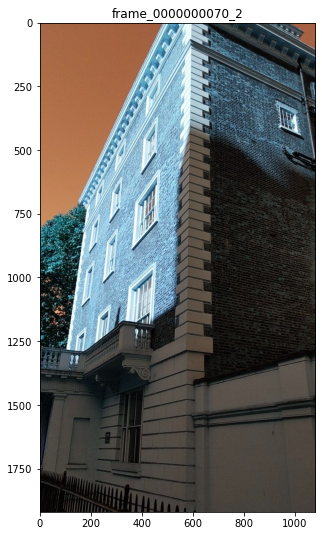

w_diag device: cpu
normals_deviced.device: cpu
delta (mean vs. cluster center): 4.71226726795077 degrees
delta (mean vs. cluster center): 2.3636399656561444 degrees
cluster_repr_normal.device: cpu
normal_indices.device: cpu
pipeline:compute_img_normals:normals_clusters_repr_sorted: [[-0.8174547  -0.31364843 -0.48310703]
 [ 0.6381697  -0.06813958 -0.7668744 ]]
pipeline:compute_img_normals:degrees_list: [97.45922475116942]
Will upsample the normals


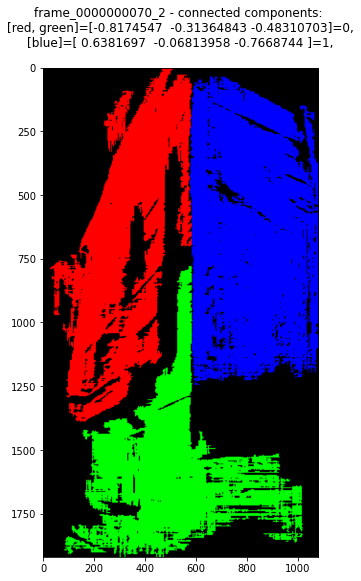

img data for frame_0000000070_2 saving into: affnet_demo/imgs//frame_0000000070_2_img_data.pkl


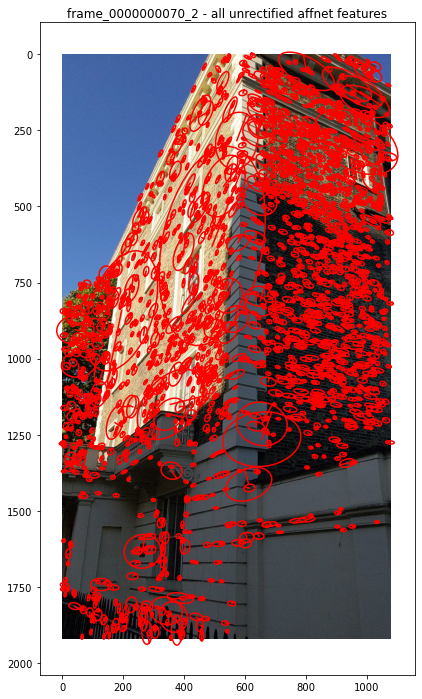

not inverted all: count: torch.Size([1, 2176])


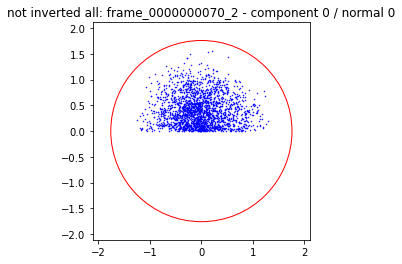

processing component->normal: 2 -> 0
not inverted unrectified: count: torch.Size([384])


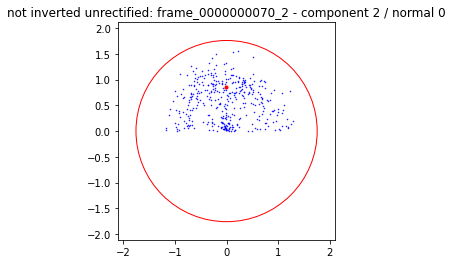

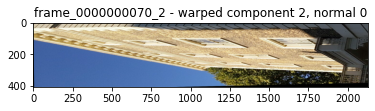

invalid back transformed pixels: 3/522


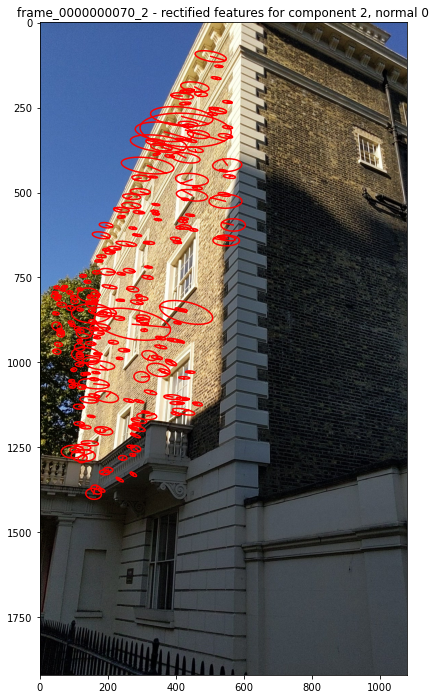

not inverted rectified: count: torch.Size([1, 219])


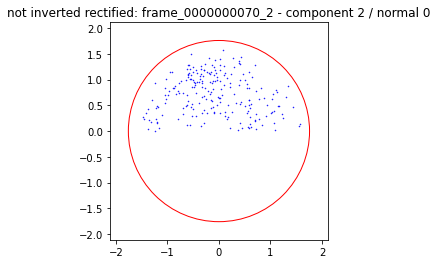

processing component->normal: 112 -> 0
not inverted unrectified: count: torch.Size([157])


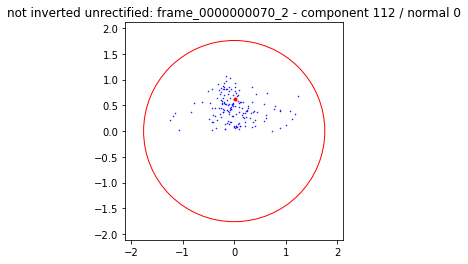

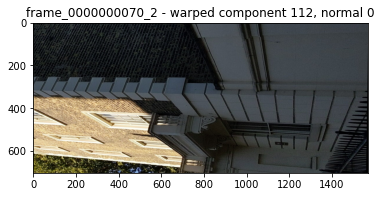

invalid back transformed pixels: 0/822


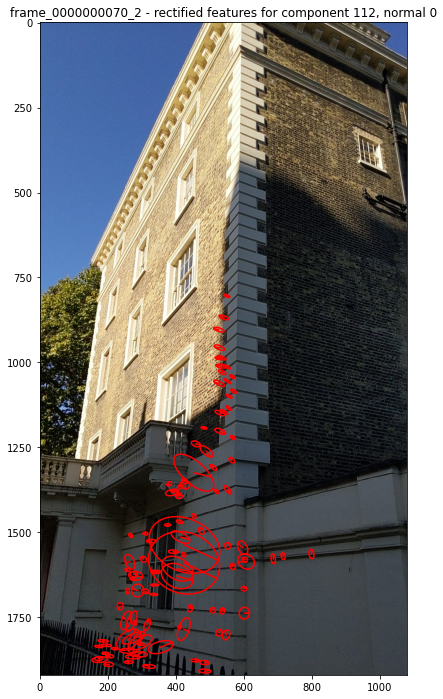

not inverted rectified: count: torch.Size([1, 106])


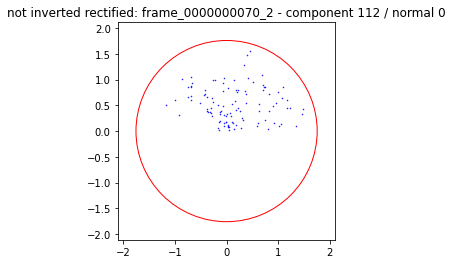

processing component->normal: 127 -> 1
not inverted unrectified: count: torch.Size([1065])


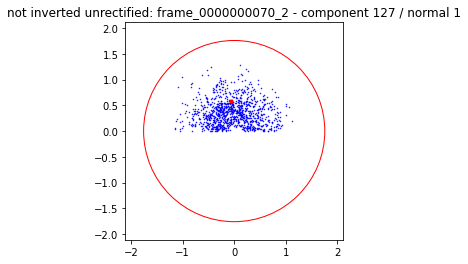

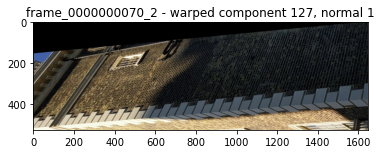

invalid back transformed pixels: 2/1315


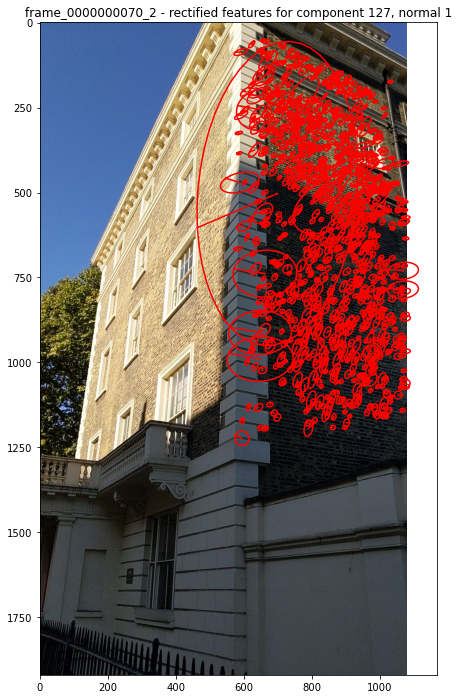

not inverted rectified: count: torch.Size([1, 1055])


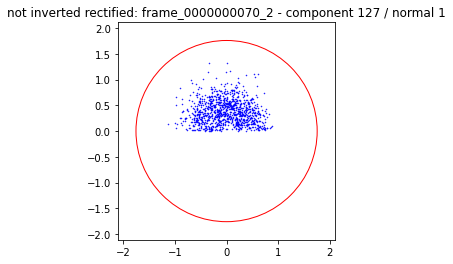

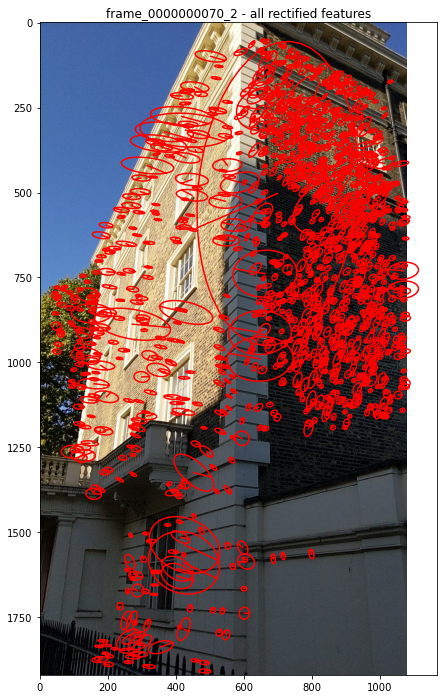

all not inverted rectified: count: torch.Size([1, 1380])


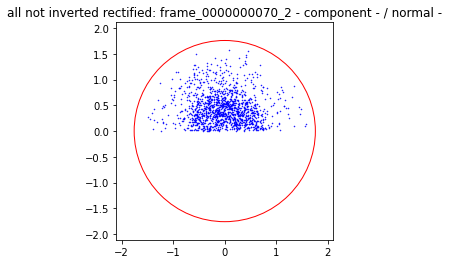

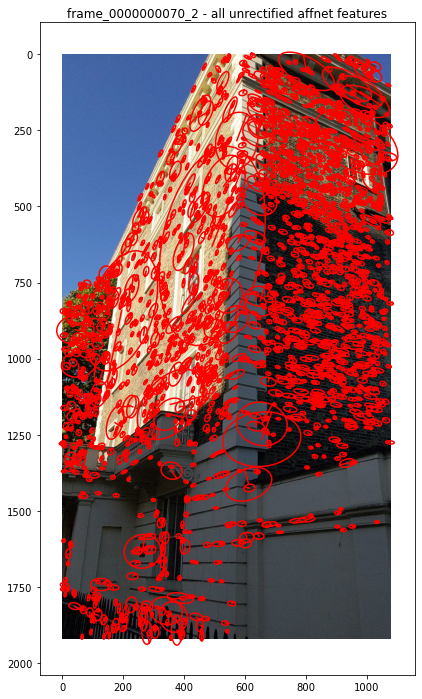

inverted all: count: torch.Size([1, 2176])


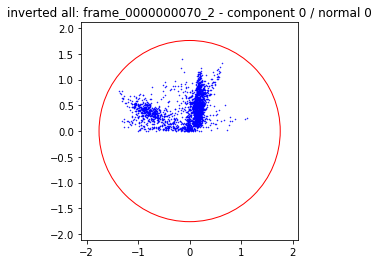

processing component->normal: 2 -> 0
inverted unrectified: count: torch.Size([384])


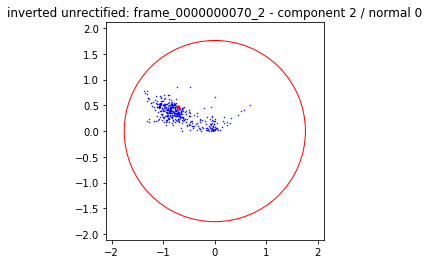

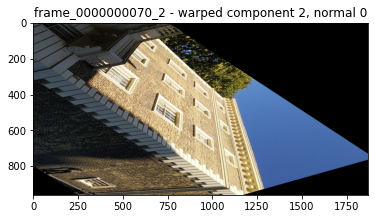

invalid back transformed pixels: 1/1574


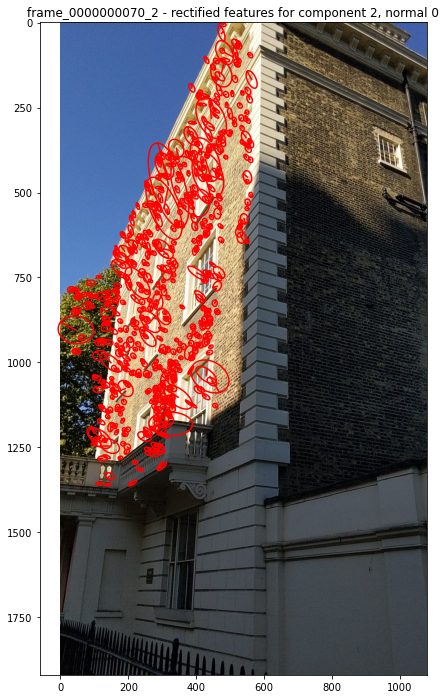

inverted rectified: count: torch.Size([1, 623])


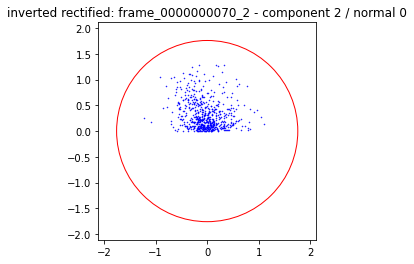

processing component->normal: 112 -> 0
inverted unrectified: count: torch.Size([157])


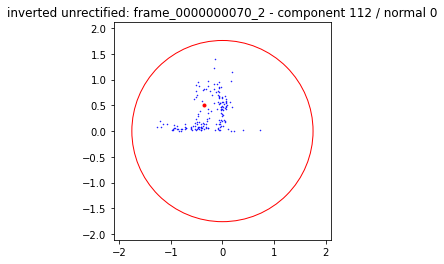

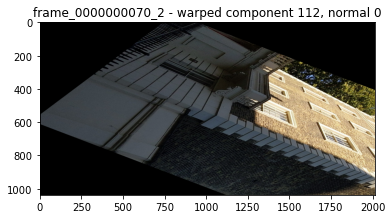

invalid back transformed pixels: 3/1484


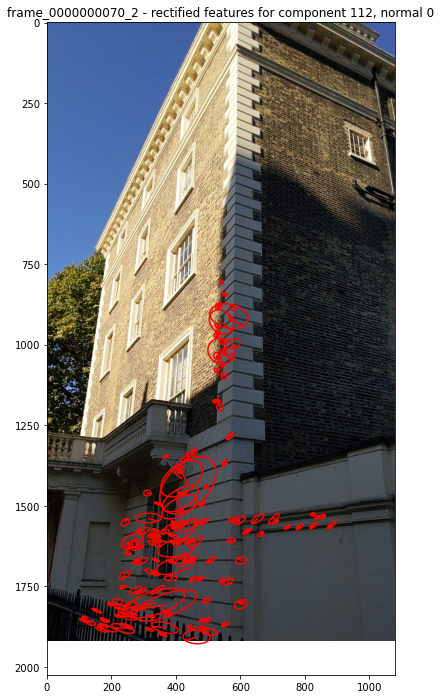

inverted rectified: count: torch.Size([1, 158])


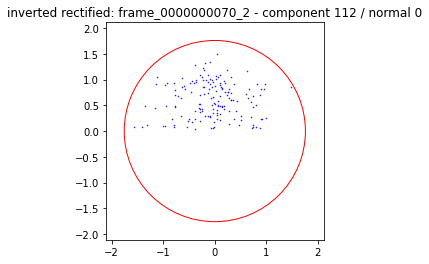

processing component->normal: 127 -> 1
inverted unrectified: count: torch.Size([1065])


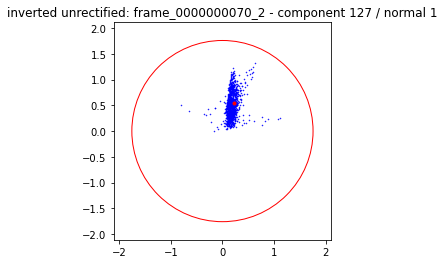

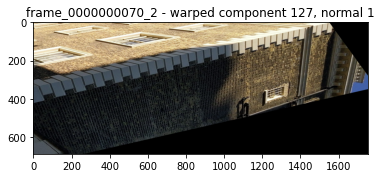

invalid back transformed pixels: 1/1386


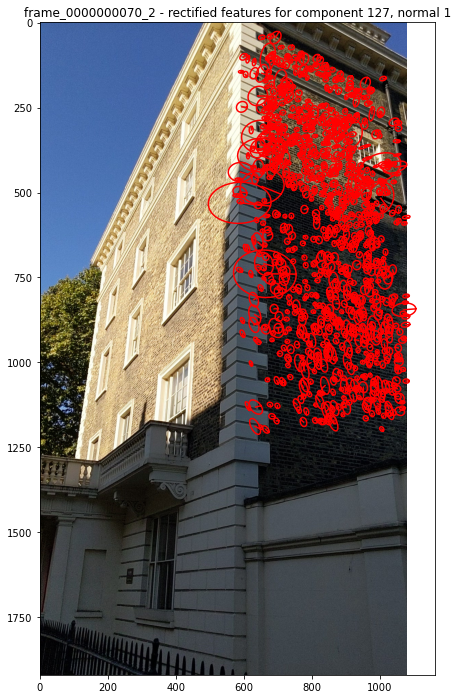

inverted rectified: count: torch.Size([1, 1024])


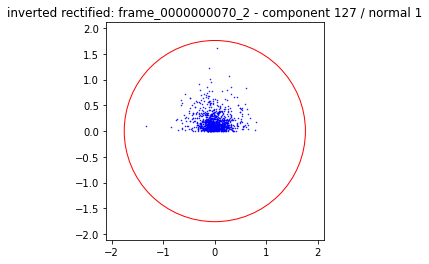

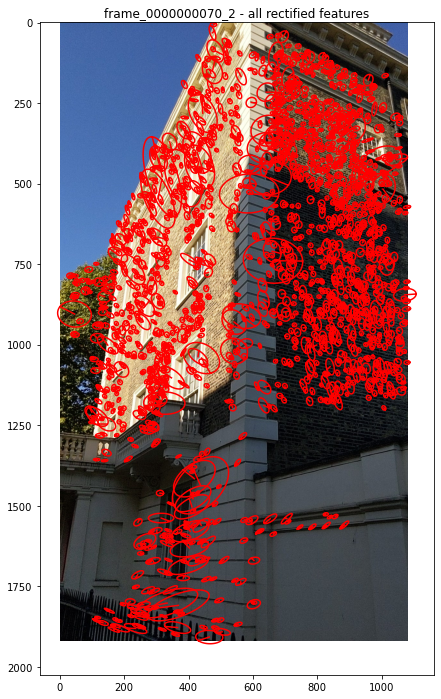

all inverted rectified: count: torch.Size([1, 1805])


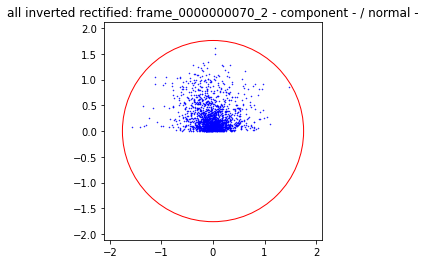

Time elapsed from start: 66.7879., 
Statistics: 
HardNetDescriptor called 3 times and it took 0.0251 secs. on average
reading scene info called 3 times and it took 1.2182 secs. on average
prepare_pipeline called 3 times and it took 1.2208 secs. on average
sky masking called 5 times and it took 1.5004 secs. on average
sky_mask called 5 times and it took 1.5079 secs. on average
quantil_mask called 5 times and it took 0.0003 secs. on average
clustering for N=300 called 5 times and it took 3.8863 secs. on average
clustering normals called 5 times and it took 3.9359 secs. on average
clustering called 5 times and it took 3.9361 secs. on average
get_connected_components called 5 times and it took 0.0872 secs. on average
processing img from scratch called 5 times and it took 6.6696 secs. on average
saving img data called 5 times and it took 0.0286 secs. on average
HadrNet.detectAndCompute called 20 times and it took 10.0464 secs. on average
decompose_lin_maps called 25 times and it took 0.0090

In [7]:
# ignore every ith feature - just to speed the demo up
hard_net_filter = 10
tilt_r = 5.8

Timer.start()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Timer.start_check_point("HardNetDescriptor")
hardnet = HardNetDescriptor(sift_descriptor=cv.SIFT_create(None), device=device)
Timer.end_check_point("HardNetDescriptor")

pipeline = prepare_pipeline()

#l = ["frame_0000000070_2", "frame_0000001525_1", "frame_0000001865_1"]
for img_name in ["frame_0000000070_2"]:
    
    img_data = pipeline.process_image(img_name, order=0)[0]
    assert len(img_data.normals.shape) == 2

    affnet_process(pipeline, img_name, hardnet, False, img_data)
    affnet_process(pipeline, img_name, hardnet, True, img_data)

Timer.log_stats()

